# Setup

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayes_toolbox.glm as bst
import os
import pandas as pd
import arviz as az
import pymc as pm
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import aesara.tensor as at

print(f"Running on PyMC v{pm.__version__}")

# Set colors for plotting
rpe_color = '#c51b7d'
te_color = '#276419'
plt.rcParams.update({'font.size': 18})

#Pymc sampling
seed_num = 100
n_samples = 10000

grp_names = ['RPE', 'TE']

Running on PyMC v4.3.0


## Define Functions

In [2]:
def robust_bayesian_mixed_model_anova(between_subj_var, within_subj_var, subj_id, y, n_draws=1000, rnd_seed=100):
    """Performs Bayesian analogue of mixed model (split-plot) ANOVA.
    
    Models instance of outcome resulting from both between- and within-subjects
    factors. Outcome is measured several times from each observational unit (i.e.,
    repeated measures). 
    
    Args:
        between_subj_var: The between-subjects variable.
        withing_subj_var: The within-subjects variable.
        subj_id: The subj ID variable. 
        y: The outcome variable. 
    
    Returns: 
        PyMC Model and InferenceData objects. 
    """
    # Statistical model: Split-plot design after Kruschke Ch. 20
    # Between-subjects factor (i.e., group)
    x_between, levels_x_between, num_levels_x_between = bst.parse_categorical(between_subj_var)
  
    # Within-subjects factor (i.e., target set)
    x_within, levels_x_within, num_levels_x_within = bst.parse_categorical(within_subj_var)

    # Individual subjects
    x_subj, levels_x_subj, num_levels_x_subj = bst.parse_categorical(subj_id)

    # Dependent variable 
    mu_y = y.mean()
    sigma_y = y.std()

    a_shape, a_rate = bst.gamma_shape_rate_from_mode_sd(sigma_y / 2 , 2 * sigma_y)

    with pm.Model(coords={
        "between_subj": levels_x_between, 
        "within_subj": levels_x_within,
        "subj": levels_x_subj}
        ) as model:

        # Baseline value
        a0 = pm.Normal('a0', mu=mu_y, sigma=sigma_y * 5)

        # Deflection from baseline for between subjects factor
        sigma_B = pm.Gamma('sigma_B', a_shape, a_rate)
        aB = pm.Normal('aB', mu=0.0, sigma=sigma_B, dims="between_subj")

        # Deflection from baseline for within subjects factor
        sigma_W = pm.Gamma('sigma_W', a_shape, a_rate)
        aW = pm.Normal('aW', mu=0.0, sigma=sigma_W, dims="within_subj")

        # Deflection from baseline for combination of between and within subjects factors
        sigma_BxW = pm.Gamma('sigma_BxW', a_shape, a_rate)
        aBxW = pm.Normal('aBxW', mu=0.0, sigma=sigma_BxW, dims=("between_subj", "within_subj"))

        # Deflection from baseline for individual subjects
        sigma_S = pm.Gamma('sigma_S', a_shape, a_rate)
        aS = pm.Normal('aS', mu=0.0, sigma=sigma_S, dims="subj")

        mu = a0 + aB[x_between] + aW[x_within] + aBxW[x_between, x_within] + aS[x_subj] 
        
        #Assumes different variances 
        sigma = pm.Uniform('sigma', lower=sigma_y / 100, upper=sigma_y * 10, dims=("between_subj", "within_subj"))

        #Prior on nu parameter
        nu_minus1 = pm.Exponential('nu_minus1', 1 / 29)
        nu = pm.Deterministic('nu', nu_minus1 + 1)     
        
        # Define likelihood 
        likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma[x_between, x_within], observed=y)
        
        # Sample from the posterior
        idata = pm.sample(draws=n_draws, tune=2000, target_accept=0.95, random_seed=rnd_seed)
    
    return model, idata

#------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------

def BEST(y, group, n_draws=1000, rnd_seed=100):
    """Implementation of John Kruschke's BEST test.
    
    Estimates parameters related to outcomes of two groups. See:
        https://jkkweb.sitehost.iu.edu/articles/Kruschke2013JEPG.pdf
        for more details. 
    
    Args:
        y (ndarray/Series): The metric outcome variable.
        group: The grouping variable providing that indexes into y.
        n_draws: Number of random samples to draw from the posterior.
    
    Returns: 
        PyMC Model and InferenceData objects.
    """
    
    # Convert grouping variable to categorical dtype if it is not already
    if pd.api.types.is_categorical_dtype(group):
        pass
    else:
        group = group.astype('category')
    group_idx = group.cat.codes.values
        
    # Extract group levels and make sure there are only two
    level = group.cat.categories
    assert len(level) == 2, f"Expected two groups but got {len(level)}."
    
    # Calculate pooled empirical mean and SD of data to scale hyperparameters
    mu_y = y.mean()
    sigma_y = y.std()
                                                                     
    with pm.Model() as model:
        # Define priors. Arbitrarily set hyperparameters to the pooled 
        # empirical mean of data and twice pooled empirical SD, which 
        # applies very diffuse and unbiased info to these quantities. 
        group_mean = pm.Normal("group_mean", mu=mu_y, sigma=sigma_y * 2, shape=len(level))
        group_std = pm.Uniform("group_std", lower=sigma_y / 10, upper=sigma_y * 10, shape=len(level))
        
        # See Kruschke Ch 16.2.1 for in-depth rationale for prior on nu. The addition of 1 is to shift the
        # distribution so that the range of possible values of nu are 1 to infinity (with mean of 30).
        nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29)
        nu = pm.Deterministic("nu", nu_minus_one + 1)
        nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))
        
        # Define likelihood
        likelihood = pm.StudentT("likelihood", nu=nu, mu=group_mean[group_idx], sigma=group_std[group_idx], observed=y)
        
        # Contrasts of interest
        diff_of_means = pm.Deterministic("difference of means", group_mean[0] - group_mean[1])
        diff_of_stds = pm.Deterministic("difference of stds", group_std[0] - group_std[1])
        effect_size = pm.Deterministic(
            "effect size", diff_of_means / np.sqrt((group_std[0]**2 + group_std[1]**2) / 2)
        )
        
        # Sample from posterior
        idata = pm.sample(draws=n_draws, tune=2000, random_seed=rnd_seed)
        
    return model, idata

#------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------

def plot_post_predictive_ttest(data, group, post, n_samps=20):
    
    grp_names = pd.unique(group)
    var_name = data.name
    # Set colors for plotting

    grp_colors = ['#c51b7d', '#276419']
    
    x = np.linspace(np.min(post.group_mean)-np.max(post.group_std),np.max(post.group_mean)+np.max(post.group_std))
    rand_idx = np.random.choice(len(post.group_mean[0,:]), n_samps)

    fig, ax = plt.subplots(1,2, figsize=(12,3))
    ax[0].hist(data[group==grp_names[0]], bins=10, density=True, alpha=0.5, color=grp_colors[0])
    for i in rand_idx:
        y = t.pdf(x, df=post.nu[i], loc=post.group_mean[0,i], scale=post.group_std[0,i])
        ax[0].plot(x, y, c=grp_colors[0], alpha=0.2)
    ax[0].set(title=grp_names[0]+' group', ylabel='probability', xlabel=var_name)

    ax[1].hist(data[group==grp_names[1]],bins=10, density=True, alpha=0.5, color=grp_colors[1])
    for i in rand_idx:
        y = t.pdf(x, df=post.nu[i], loc=post.group_mean[1,i], scale=post.group_std[1,i])
        ax[1].plot(x, y, c=grp_colors[1], alpha=0.2)
    ax[1].set(title=grp_names[1]+' group', xlabel=var_name)
    
    plt.show()
    
#------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------

def plot_post_simple_comparison(idata, grp_names, round_to):

    az.plot_posterior(
        idata,
        var_names=["difference of means", "difference of stds", "effect size"],
        ref_val=0,
        color="#87ceeb",
        kind="hist",
        round_to=round_to,
        point_estimate="mean",
        bins=50,
        hdi_prob=0.95,
    );
    
    summary = az.summary(idata,hdi_prob=0.95)

    print(grp_names[0], 'mean [95% HDI] =', round(summary['mean'][0],round_to), '[', round(summary['hdi_2.5%'][0],round_to), round(summary['hdi_97.5%'][0],round_to), ']')
    print(grp_names[1], 'mean [95% HDI] =', round(summary['mean'][1],round_to), '[', round(summary['hdi_2.5%'][1],round_to), round(summary['hdi_97.5%'][1],round_to), ']')
    print('Difference of means =', round(summary['mean'][7],round_to), '[', round(summary['hdi_2.5%'][7],round_to), round(summary['hdi_97.5%'][7],round_to), ']')
      
#------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------

def plot_mustache_tdist(mu, sigma, nu, plot_pos, width, color, ax=None):
    for m, s, n in zip(mu, sigma, nu):

        rv = t(df=n, loc=m, scale=s)
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        xrange_scaled = xrange*(width/xrange.max())
        ax.plot(-xrange_scaled+plot_pos, yrange, color=color, alpha=.2)
        
#------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------

def plot_posterior_predictive_anova_robust(between_subj, within_subj, y, post, n_mustaches):
            
    #Index group names
    bs_names = pd.unique(between_subj)
    ws_names = pd.unique(within_subj)
    
    #For indexing posterior
    burn_in = post.tuning_steps
    all_post_idx = np.arange(len(post.sample))
    post_idx = np.random.randint(burn_in+1, all_post_idx[-1], n_mustaches)
    
    #Plot prep
    group_colors = ['#c51b7d', '#276419']
    x_offset = [-0.15, 0.15]
    
    #Initilize plot
    fig, ax = plt.subplots(figsize=(10,5),tight_layout=True)
    ax.plot(np.arange(0,len(ws_names)+2), np.zeros(len(ws_names)+2), 'k')
    
    for ws_idx, ws in enumerate(ws_names):
        for bs_idx, bs in enumerate(bs_names):
            #Index and plot emperical data
            y_emp = y[within_subj==ws][between_subj==bs]
            x = norm.rvs(1+ws_idx+x_offset[bs_idx],0.005,len(y_emp))
            ax.plot(x, y_emp, 'o', c=group_colors[bs_idx], mec='w', alpha=0.5)
            
            #Index and plot posterior data
            plot_mustache_tdist(mu=post.b0.values[post_idx]+
                          post.bB.sel(between_subj=bs).values[post_idx]+
                          post.bW.sel(within_subj=ws).values[post_idx]+
                          post.bBxW.sel(between_subj=bs,within_subj=ws).values[post_idx], 
                          sigma=post.sigma.sel(between_subj=bs,within_subj=ws).values[post_idx], 
                          nu=post.nu.values[post_idx], 
                          plot_pos=0.95+ws_idx+x_offset[bs_idx], 
                          width=0.15, 
                          color=group_colors[bs_idx], ax=ax)
            
    ax.set(xlim=(0.5, len(ws_names)+0.5), 
           xticks=np.arange(1,len(ws_names)+1), 
           xticklabels=ws_names, 
           ylabel=y.name, 
           title='Posterior Predictive Check (' + y.name + ')'
          )
    plt.show()

#------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------

def plot_between_contrasts(post, between_subj, within_subj, round_to):

    #Index the between and within subject names
    bs_names = pd.unique(between_subj)
    ws_names = pd.unique(within_subj)
    
    print('Interactions:')
    
    #Index the interaction contrasts
    contrast_dict = {}
    for ws_idx, ws in enumerate(ws_names):
        single_contrast = []
        for bs_idx, bs in enumerate(bs_names):
            
            post_indiv = post.b0 + post.bB.sel(between_subj=bs) + post.bW.sel(within_subj=ws) + post.bBxW.sel(between_subj=bs,within_subj=ws)
            post_hdi = az.hdi(post_indiv.values, hdi_prob=0.95)
            print('Posterior for', bs, ws, '=', np.round(np.mean(post_indiv.values),round_to), np.round(post_hdi,round_to))
         
            single_contrast.append(post_indiv)

        contrast_str = bs_names[0] + ' vs ' + bs_names[1] + ' @ ' + ws
        contrast = single_contrast[0] - single_contrast[1]        
        contrast_hdi = az.hdi(contrast.values, hdi_prob=0.95)
        
        print(contrast_str, '=', np.round(np.mean(contrast.values),round_to), np.round(contrast_hdi,round_to))
        print(' ')
        
        contrast_dict[contrast_str] = contrast
    az.plot_posterior(contrast_dict, 
                      kind="hist",
                      combine_dims={"sample"},
                      bins=50,
                      point_estimate="mean", 
                      ref_val=0,
                      round_to=round_to,
                      hdi_prob=0.95);
    
#------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------
    
def perception_regression(x_percept, y, group):
    
    x_grp, levels_x_grp, _ = bst.parse_categorical(group)
    
    with pm.Model(coords={"group": levels_x_grp}) as model:
        # Define priors
        alpha_group = pm.Normal("alpha_group", mu=0, sigma=100, dims="group")
        beta_percept = pm.Normal("beta_percept", mu=0, sigma=100, dims="group")

        delta = pm.Dirichlet("delta", np.repeat(2.0,2), shape=2)
        delta_j = at.concatenate([at.zeros(1), delta])
        delta_j_cumulative = at.cumsum(delta_j)

        mu = alpha_group[x_grp] + beta_percept[x_grp]*delta_j_cumulative[x_percept]
        sigma = pm.Uniform("sigma", 10**-10, 1000)

        nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29)
        nu = pm.Exponential("nu", nu_minus_one + 1)
        nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))

        # Define likelihood
        likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, lam=1 / sigma**2, observed=y)

        # Sample the posterior
        idata = pm.sample(draws=n_samples, tune=2000, target_accept=0.95, random_seed=seed_num, chains=4, cores=8, init='auto')
        
    az.plot_trace(idata);

    posterior = az.extract(idata.posterior)

    return idata, posterior

#------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------
  
def posterior_predictive_regression(post, perception_cat, df):
    
    rpe_color = '#c51b7d'
    te_color = '#276419'

    post_deltas = np.array([post.delta.values[0], 
                            post.delta.values[1]])
    
    #Prep plot for regression
    mu_hat_rpe = np.zeros((len(perception_cat.categories), len(post.sample)))
    mu_hat_te = np.zeros((len(perception_cat.categories), len(post.sample)))
    for i in range(3):
        mu_hat_rpe[i] = post.alpha_group.sel(group='rpe').values + post.beta_percept.sel(group='rpe').values * np.sum(post_deltas[:i,:],axis=0)
        mu_hat_te[i] = post.alpha_group.sel(group='te').values + post.beta_percept.sel(group='te').values * np.sum(post_deltas[:i,:],axis=0)

        
    group=df.group
    y=df.ret_prct
    
    fig, ax = plt.subplots()
    for i, p in enumerate(perception_cat.categories):
        ax.plot(i, np.mean(y[(perception_cat==p) & (group=='rpe')]), 'o', c=rpe_color, ms=10)
        ax.plot(i, np.mean(y[(perception_cat==p) & (group=='te')]), 'o', c=te_color, ms=10)
        ax.plot(np.ones(len(y[(perception_cat==p) & (group=='rpe')]))*i + 0.1, y[(perception_cat==p) & (group=='rpe')], '.', c=rpe_color)
        ax.plot(np.ones(len(y[(perception_cat==p) & (group=='te')]))*i - 0.1, y[(perception_cat==p) & (group=='te')], '.', c=te_color)

    az.plot_hdi(np.arange(3), mu_hat_rpe.T, color=rpe_color, ax=ax, hdi_prob=0.95)
    az.plot_hdi(np.arange(3), mu_hat_te.T, color=te_color, ax=ax, hdi_prob=0.95)
    ax.plot(np.arange(3), np.mean(mu_hat_rpe, axis=1), c=rpe_color, lw=3)
    ax.plot(np.arange(3), np.mean(mu_hat_te, axis=1), c=te_color, lw=3)

    ax.set(ylabel='percent retention', xlabel='LSL Perception', ylim=(0, 200), xlim=(-0.5, 2.5), xticks=[0,1,2], xticklabels=perception_cat.categories)
    plt.show()   

## Load the data

In [8]:
#Change the directory
os.chdir('/Users/jonathanwood/Documents/GitHub/Reinforcement-learning-in-locomotion/Data')

#Load experiment 1 data
df1 = pd.read_csv('E1_results_anova.txt')

#Load exploration data
df_var = pd.read_csv('variability_anova.txt')
df1_var = df_var[df_var.experiment==1]
df2_var = df_var[df_var.experiment==2]

#Load experiment 2 data
df2 = pd.read_csv('E2_results_anova.txt')

# Experiment 1

## Learning

### Late Learning

In [ ]:
#Run the model
model_lrn_e1, idata_lrn_e1 = BEST(y=df1.learning[df1.time=="Late"], 
                                  group=df1.group[df1.time=="Late"],
                                  n_draws=n_samples, rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 31 seconds.


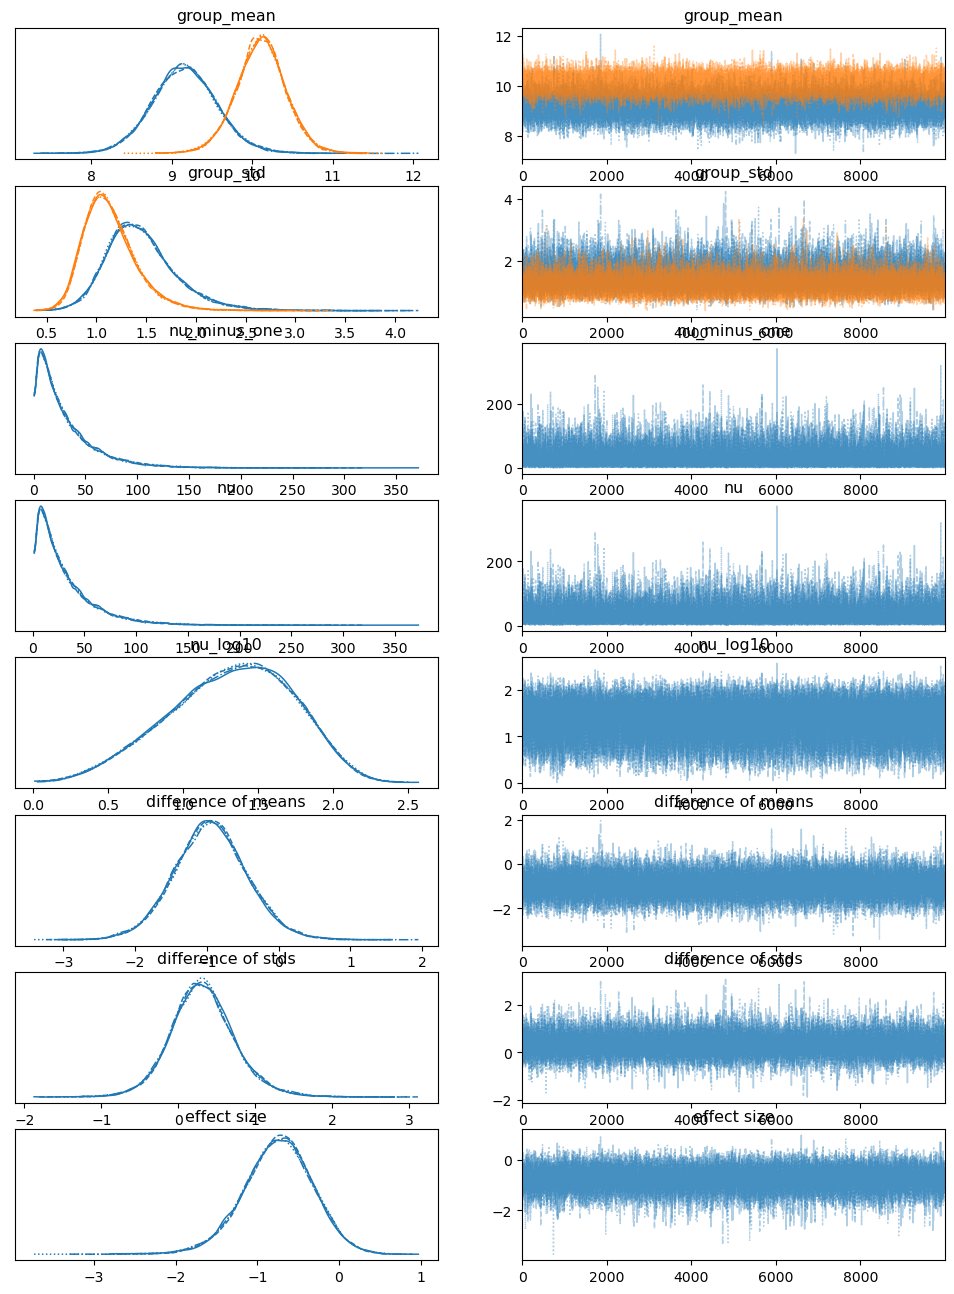

In [ ]:
az.plot_trace(idata_lrn_e1);

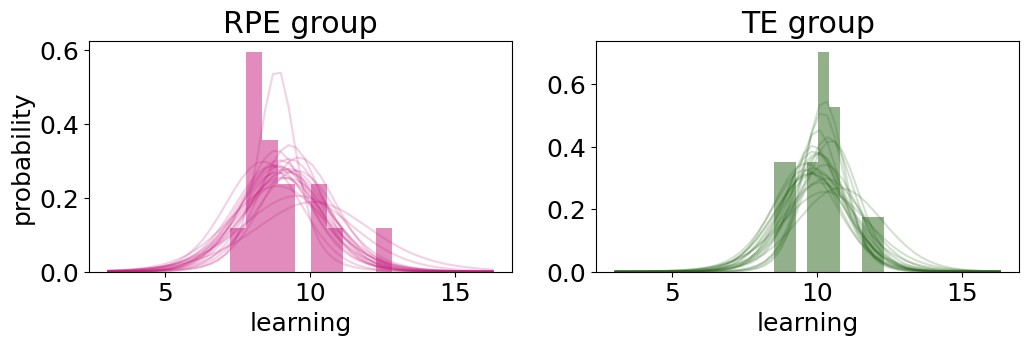

In [ ]:
#Extract posterior
post_lrn_e1 = az.extract(idata_lrn_e1)

#Plot posterior predictive
plot_post_predictive_ttest(df1.learning[df1.time=="Late"],
                           df1.group[df1.time=="Late"], 
                           post_lrn_e1, 
                           n_samps=20)

RPE mean [95% HDI] = 9.16 [ 8.36 9.95 ]
TE mean [95% HDI] = 10.11 [ 9.49 10.71 ]
Difference of means = -0.94 [ -1.99 0.02 ]


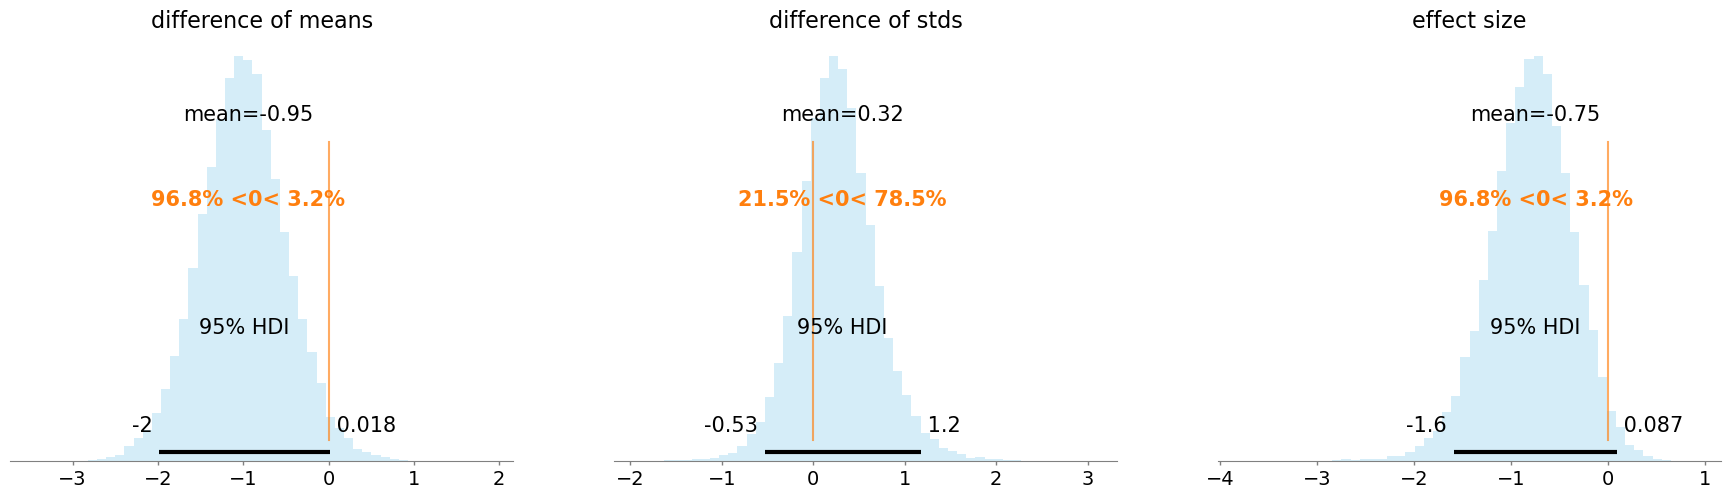

In [ ]:
plot_post_simple_comparison(idata_lrn_e1, grp_names, round_to=2)

### Error

In [14]:
#Run the model
model_error_e1, idata_error_e1 = robust_bayesian_mixed_model_anova(between_subj_var=df1.group, 
                                                                   within_subj_var=df1.time, 
                                                                   subj_id=df1.subj_id, 
                                                                   y=df1.error, 
                                                                   n_draws=n_samples, 
                                                                   rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 3522 seconds.


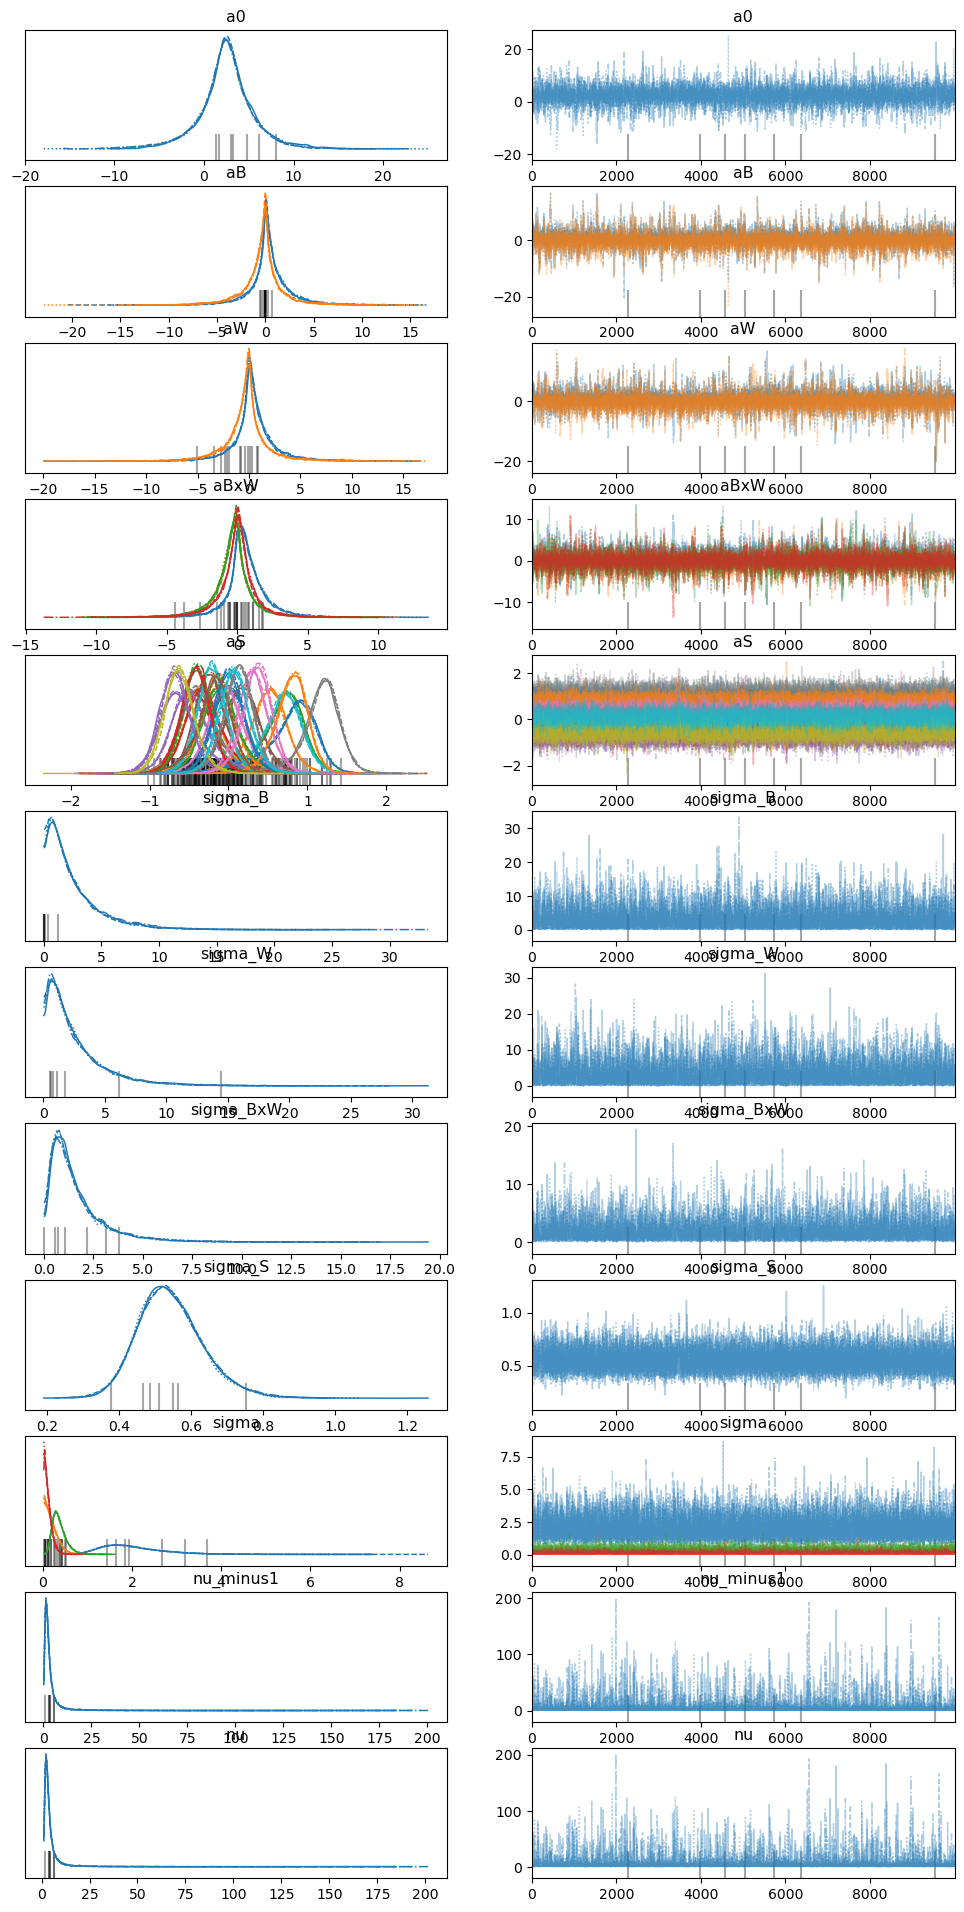

In [15]:
az.plot_trace(idata_error_e1);

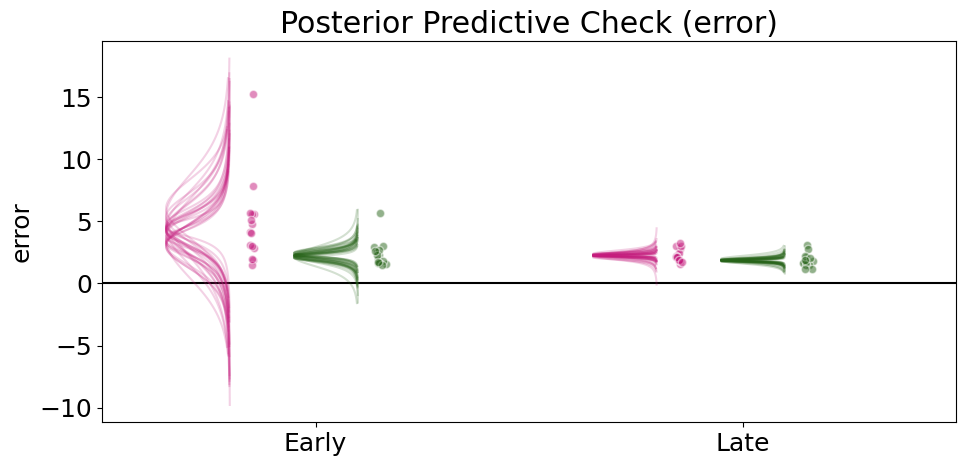

In [16]:
# Convert coefficients to sum-to-zero deflections
post_error_e1 = bst.convert_to_sum_to_zero(idata_error_e1, 
                                           df1.group, 
                                           df1.time, 
                                           df1.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df1.group, 
                                       within_subj=df1.time, 
                                       y=df1.error, 
                                       post=post_error_e1, 
                                       n_mustaches=25)

Interactions:
Posterior for RPE Early = 3.91 [2.628 5.111]
Posterior for TE Early = 2.295 [2.057 2.535]
RPE vs TE @ Early = 1.615 [0.321 2.839]
 
Posterior for RPE Late = 2.253 [2.082 2.418]
Posterior for TE Late = 1.857 [1.738 1.952]
RPE vs TE @ Late = 0.396 [0.2   0.585]
 


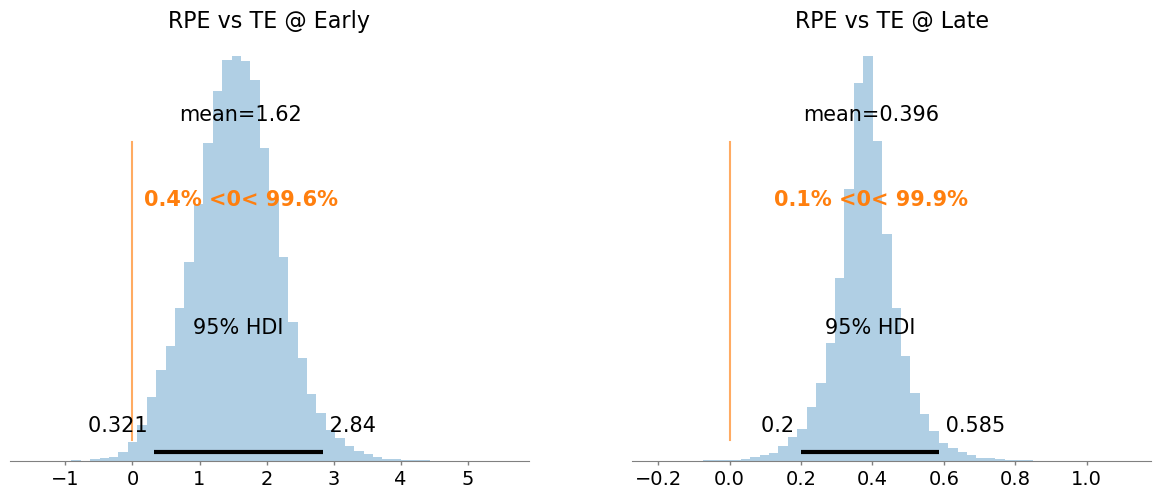

In [17]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_error_e1, 
                       between_subj=df1.group, 
                       within_subj=df1.time, 
                       round_to=3)

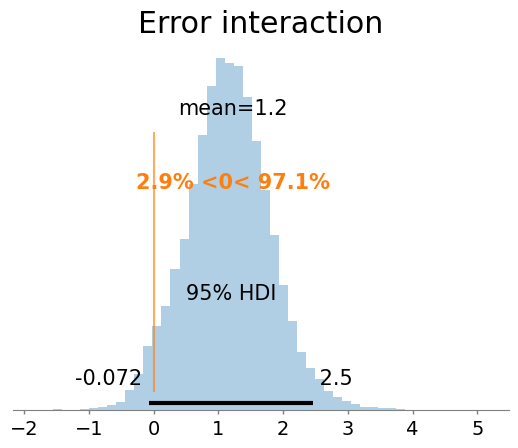

In [18]:
#Interaction effect

#Index posteriors
post_rpe_early = post_error_e1.b0 + post_error_e1.bB.sel(between_subj='RPE') + post_error_e1.bW.sel(within_subj='Early') + post_error_e1.bBxW.sel(between_subj='RPE',within_subj='Early')
post_te_early = post_error_e1.b0 + post_error_e1.bB.sel(between_subj='TE') + post_error_e1.bW.sel(within_subj='Early') + post_error_e1.bBxW.sel(between_subj='TE',within_subj='Early')

post_rpe_late = post_error_e1.b0 + post_error_e1.bB.sel(between_subj='RPE') + post_error_e1.bW.sel(within_subj='Late') + post_error_e1.bBxW.sel(between_subj='RPE',within_subj='Late')
post_te_late = post_error_e1.b0 + post_error_e1.bB.sel(between_subj='TE') + post_error_e1.bW.sel(within_subj='Late') + post_error_e1.bBxW.sel(between_subj='TE',within_subj='Late')

#Differences
time_diff_rpe = post_rpe_early - post_rpe_late
time_diff_te = post_te_early - post_te_late
error_interaction = time_diff_rpe - time_diff_te

#Plot
az.plot_posterior(error_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('Error interaction')
plt.show()

### Percent success


In [19]:
#Run the model
model_success_e1, idata_success_e1 = robust_bayesian_mixed_model_anova(between_subj_var=df1.group, 
                                                                       within_subj_var=df1.time, 
                                                                       subj_id=df1.subj_id, 
                                                                       y=df1.success, 
                                                                       n_draws=n_samples, 
                                                                       rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 2634 seconds.


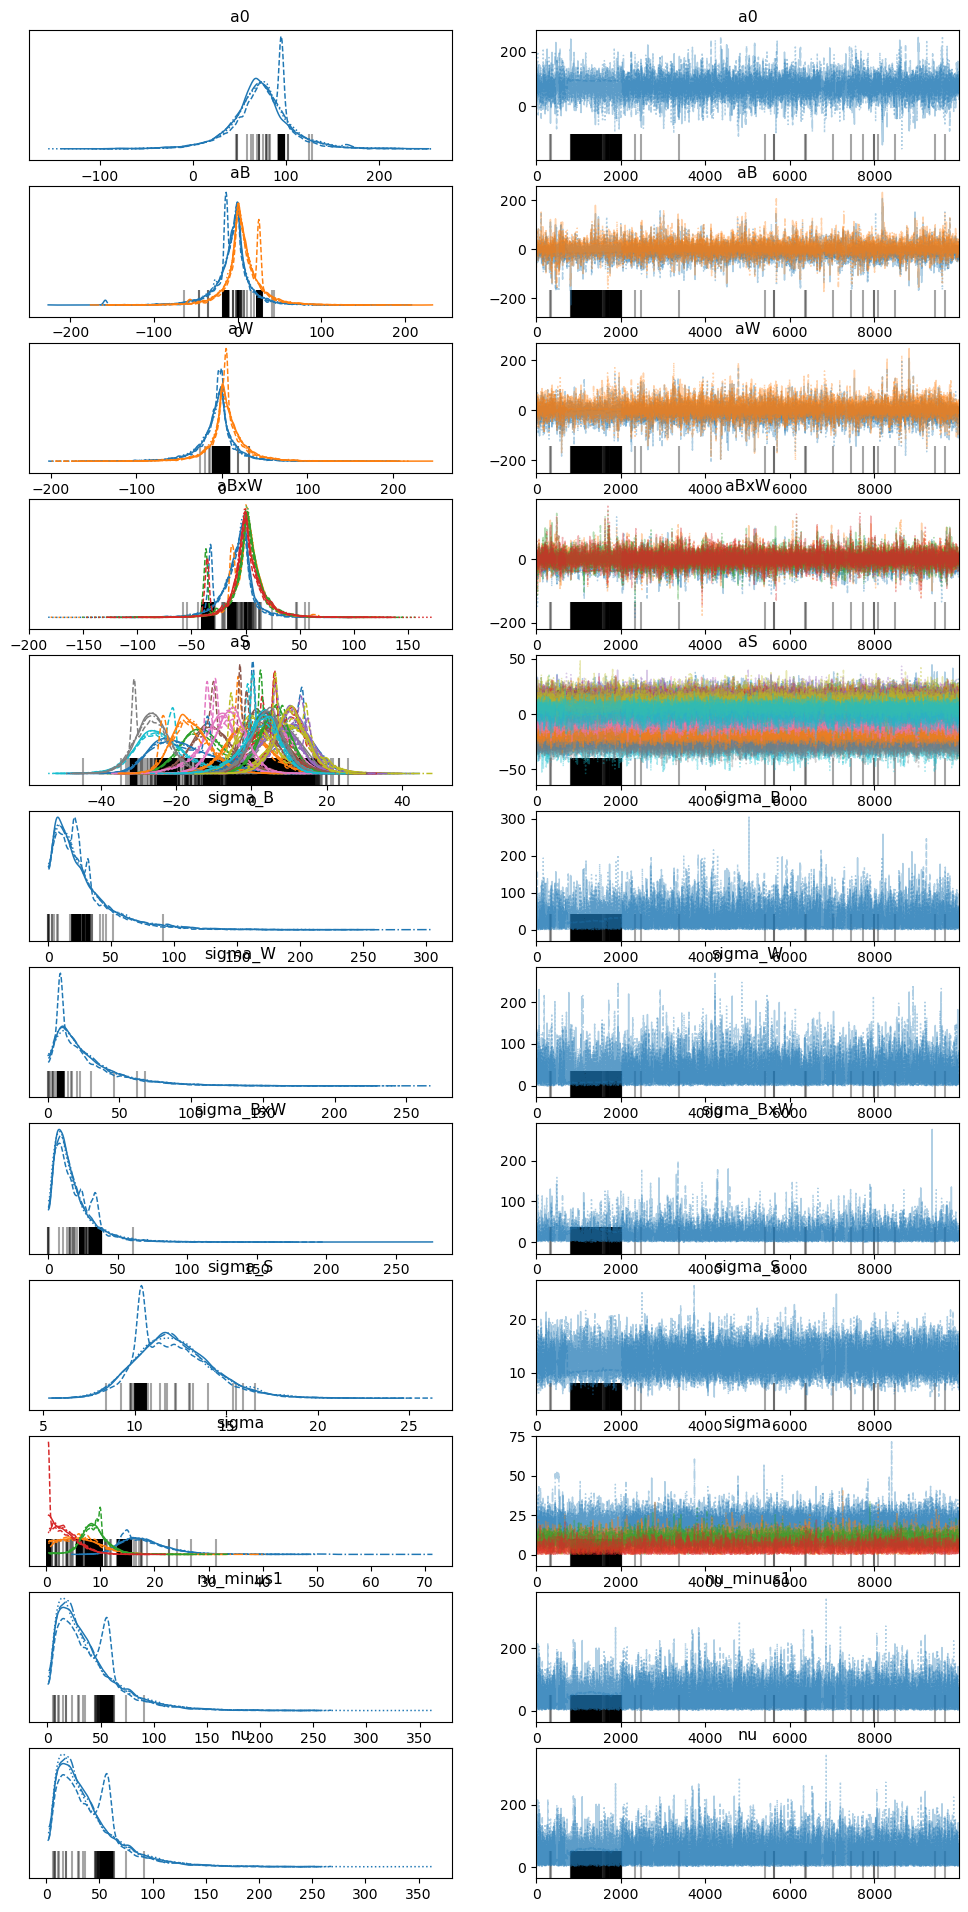

In [20]:
az.plot_trace(idata_success_e1);

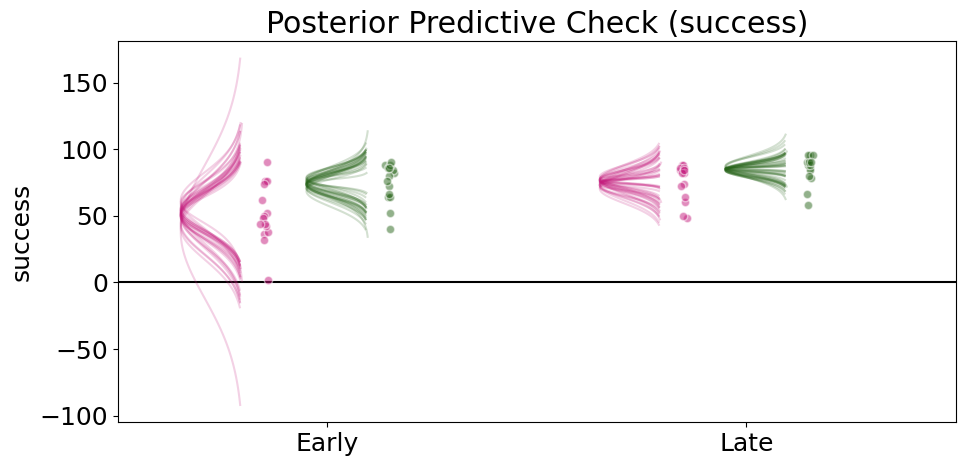

In [21]:
# Convert coefficients to sum-to-zero deflections
post_success_e1 = bst.convert_to_sum_to_zero(idata_success_e1, 
                                             df1.group, 
                                             df1.time, 
                                             df1.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df1.group, 
                                       within_subj=df1.time, 
                                       y=df1.success, 
                                       post=post_success_e1, 
                                       n_mustaches=25)

Interactions:
Posterior for RPE Early = 52.481 [42.578 63.419]
Posterior for TE Early = 74.371 [69.382 79.206]
RPE vs TE @ Early = -21.89 [-33.067 -10.229]
 
Posterior for RPE Late = 75.35 [71.185 79.556]
Posterior for TE Late = 85.225 [82.717 87.835]
RPE vs TE @ Late = -9.875 [-14.724  -5.114]
 


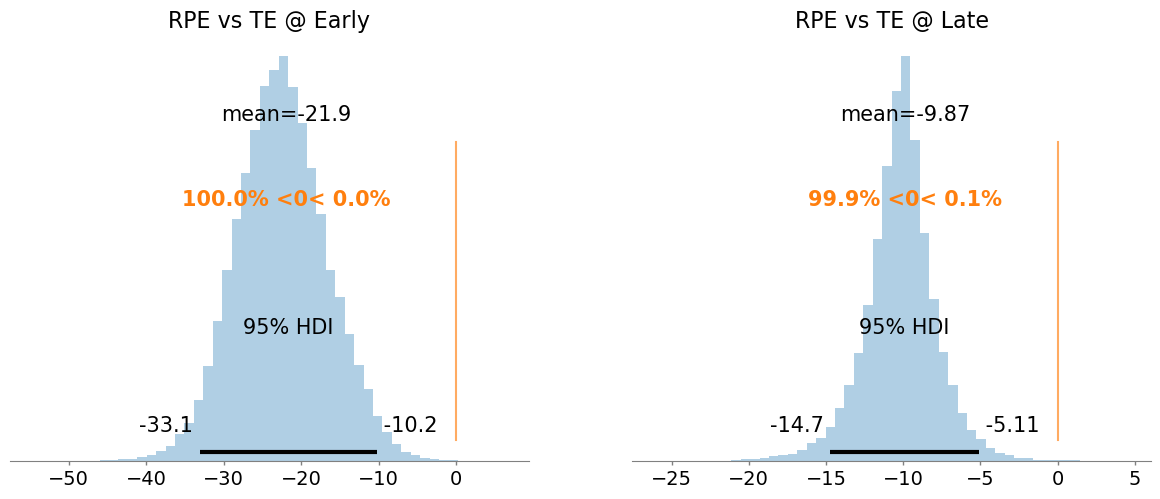

In [22]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_success_e1, 
                       between_subj=df1.group, 
                       within_subj=df1.time, 
                       round_to=3)

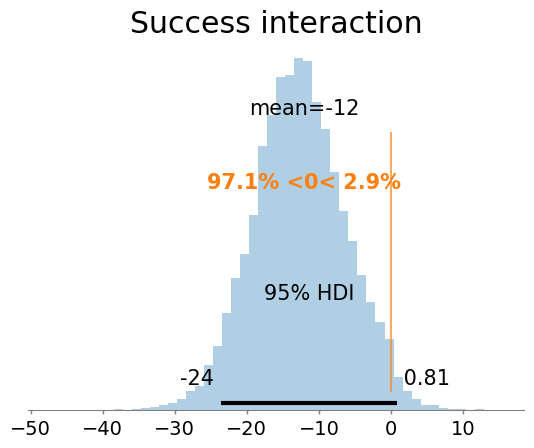

In [23]:
#Interaction effect

#Index posteriors
post_rpe_early = post_success_e1.b0 + post_success_e1.bB.sel(between_subj='RPE') + post_success_e1.bW.sel(within_subj='Early') + post_success_e1.bBxW.sel(between_subj='RPE',within_subj='Early')
post_te_early = post_success_e1.b0 + post_success_e1.bB.sel(between_subj='TE') + post_success_e1.bW.sel(within_subj='Early') + post_success_e1.bBxW.sel(between_subj='TE',within_subj='Early')

post_rpe_late = post_success_e1.b0 + post_success_e1.bB.sel(between_subj='RPE') + post_success_e1.bW.sel(within_subj='Late') + post_success_e1.bBxW.sel(between_subj='RPE',within_subj='Late')
post_te_late = post_success_e1.b0 + post_success_e1.bB.sel(between_subj='TE') + post_success_e1.bW.sel(within_subj='Late') + post_success_e1.bBxW.sel(between_subj='TE',within_subj='Late')

#Differences
time_diff_rpe = post_rpe_early - post_rpe_late
time_diff_te = post_te_early - post_te_late
success_interaction = time_diff_rpe - time_diff_te

#Plot
az.plot_posterior(success_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('Success interaction')
plt.show()

## Exploration

### Motor variability

In [24]:
model_var_e1, idata_var_e1 = robust_bayesian_mixed_model_anova(between_subj_var=df1_var.group, 
                                                               within_subj_var=df1_var.time, 
                                                               subj_id=df1_var.subj_id, 
                                                               y=df1_var.variability, 
                                                               n_draws=n_samples,
                                                               rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 8943 seconds.


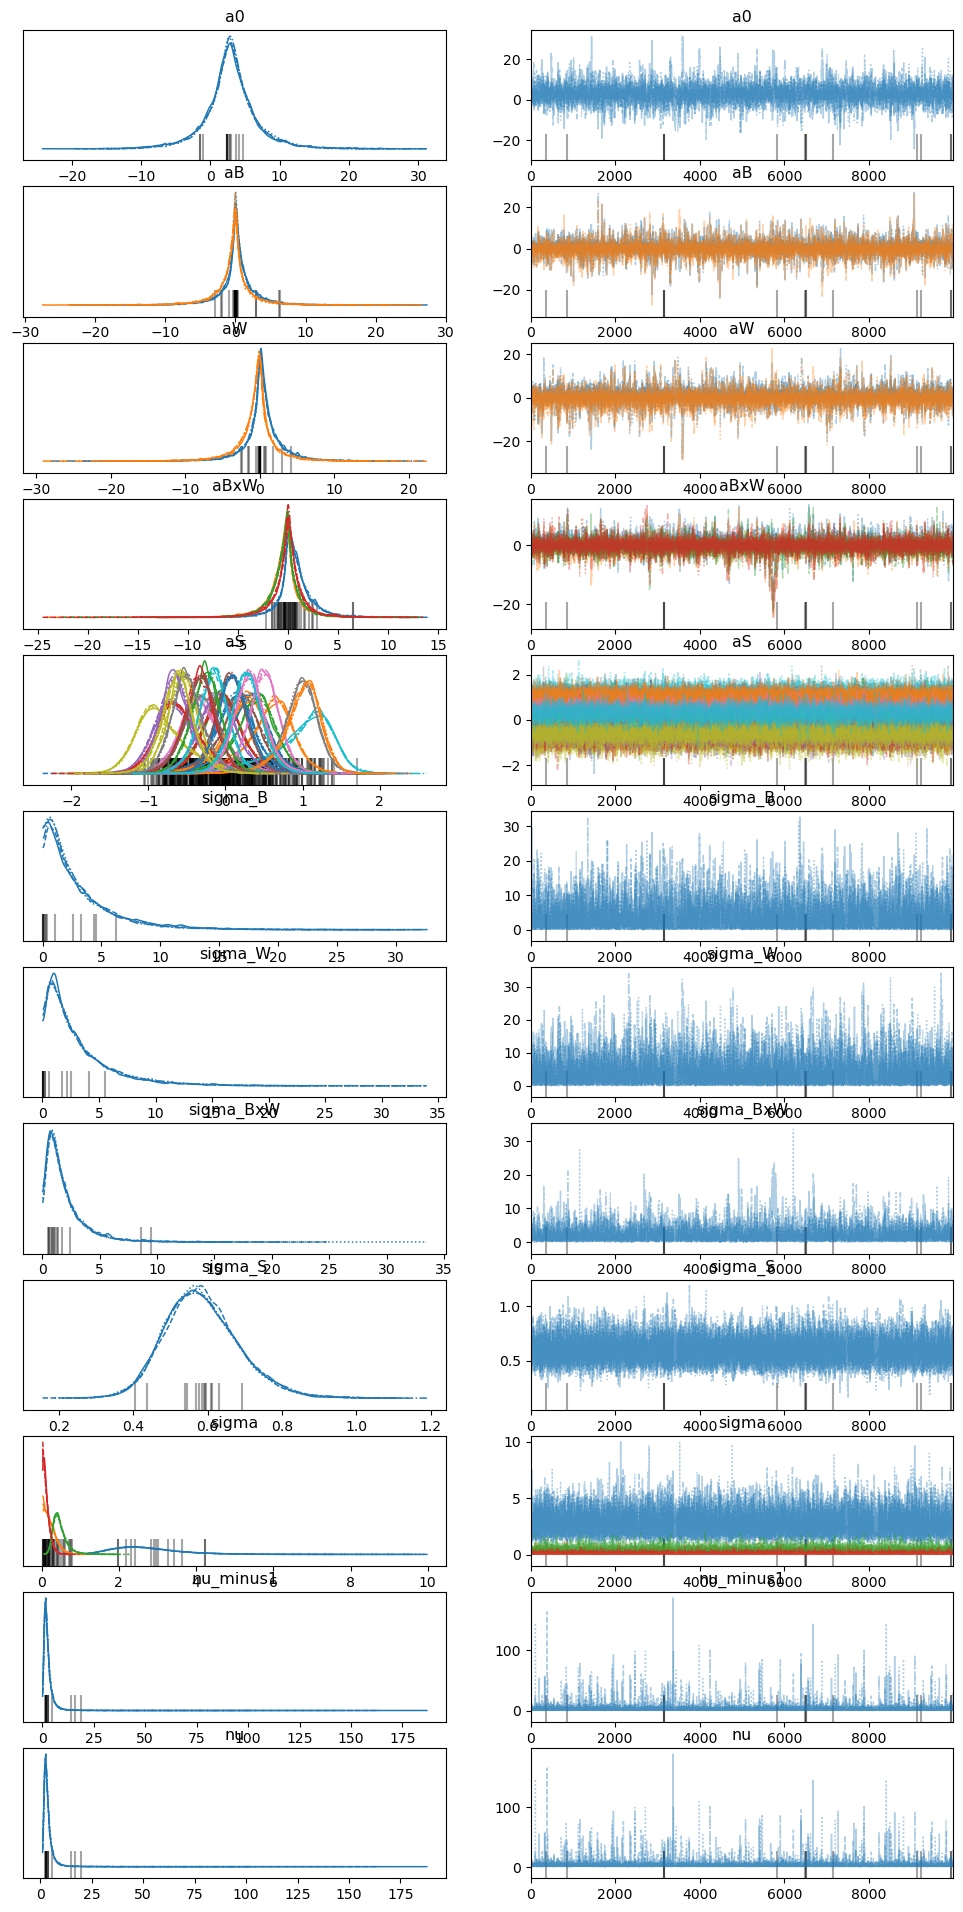

In [ ]:
az.plot_trace(idata_var_e1);

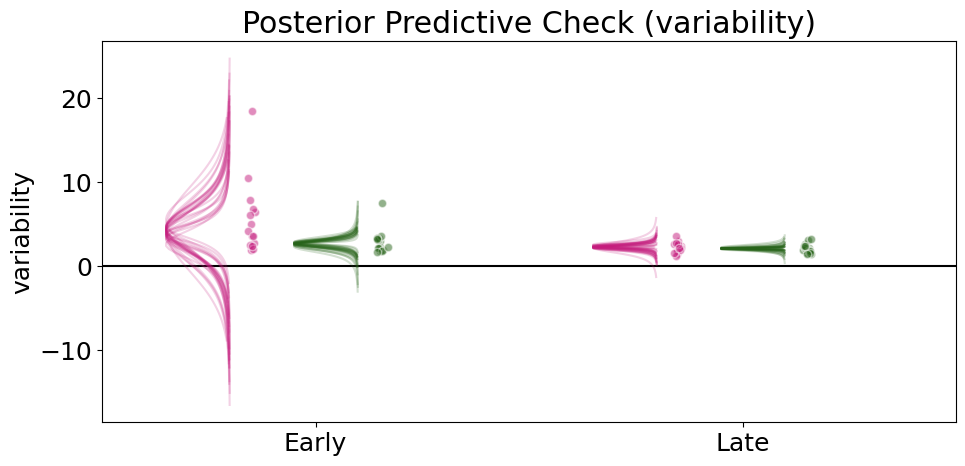

In [ ]:
# Convert coefficients to sum-to-zero deflections
post_var_e1 = bst.convert_to_sum_to_zero(idata_var_e1, 
                                               df1_var.group, 
                                               df1_var.time, 
                                               df1_var.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df1_var.group, 
                                       within_subj=df1_var.time, 
                                       y=df1_var.variability, 
                                       post=post_var_e1, 
                                       n_mustaches=25)

Interactions:
Posterior for RPE Early = 4.289 [2.638 5.976]
Posterior for TE Early = 2.691 [2.398 3.01 ]
RPE vs TE @ Early = 1.598 [-0.031  3.316]
 
Posterior for RPE Late = 2.298 [2.109 2.495]
Posterior for TE Late = 2.138 [2.022 2.247]
RPE vs TE @ Late = 0.16 [-0.063  0.374]
 


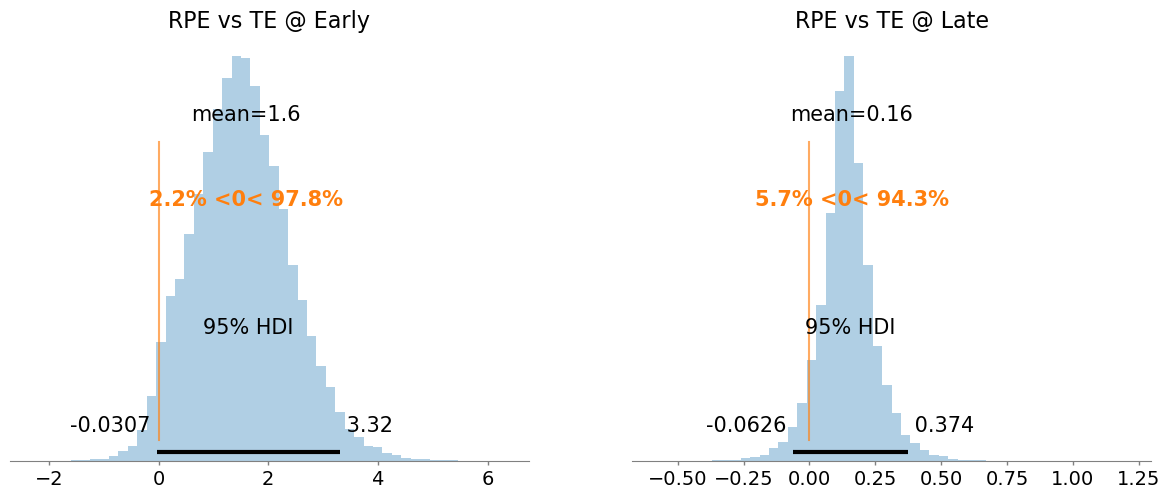

In [ ]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_var_e1, 
                       between_subj=df1_var.group, 
                       within_subj=df1_var.time, 
                       round_to=3)

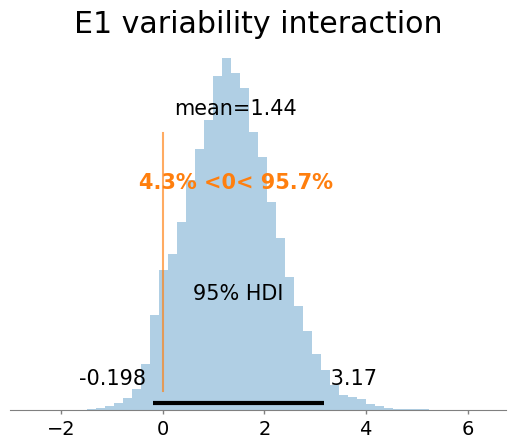

In [29]:
#Interaction effect

#Index posteriors
post_rpe_early = post_var_e1.b0 + post_var_e1.bB.sel(between_subj='RPE') + post_var_e1.bW.sel(within_subj='Early') + post_var_e1.bBxW.sel(between_subj='RPE',within_subj='Early')
post_te_early = post_var_e1.b0 + post_var_e1.bB.sel(between_subj='TE') + post_var_e1.bW.sel(within_subj='Early') + post_var_e1.bBxW.sel(between_subj='TE',within_subj='Early')

post_rpe_late = post_var_e1.b0 + post_var_e1.bB.sel(between_subj='RPE') + post_var_e1.bW.sel(within_subj='Late') + post_var_e1.bBxW.sel(between_subj='RPE',within_subj='Late')
post_te_late = post_var_e1.b0 + post_var_e1.bB.sel(between_subj='TE') + post_var_e1.bW.sel(within_subj='Late') + post_var_e1.bBxW.sel(between_subj='TE',within_subj='Late')

#Differences
time_diff_rpe = post_rpe_early - post_rpe_late
time_diff_te = post_te_early - post_te_late
e1var_interaction = time_diff_rpe - time_diff_te

#Plot
az.plot_posterior(e1var_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=3,
                  hdi_prob=0.95);
plt.title('E1 variability interaction')
plt.show()

### Win stay lose shift

In [30]:
model_exp_e1, idata_exp_e1 = robust_bayesian_mixed_model_anova(between_subj_var=df1_var.group, 
                                                               within_subj_var=df1_var.exp_time, 
                                                               subj_id=df1_var.subj_id, 
                                                               y=df1_var.wsls, 
                                                               n_draws=n_samples,
                                                               rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 3957 seconds.


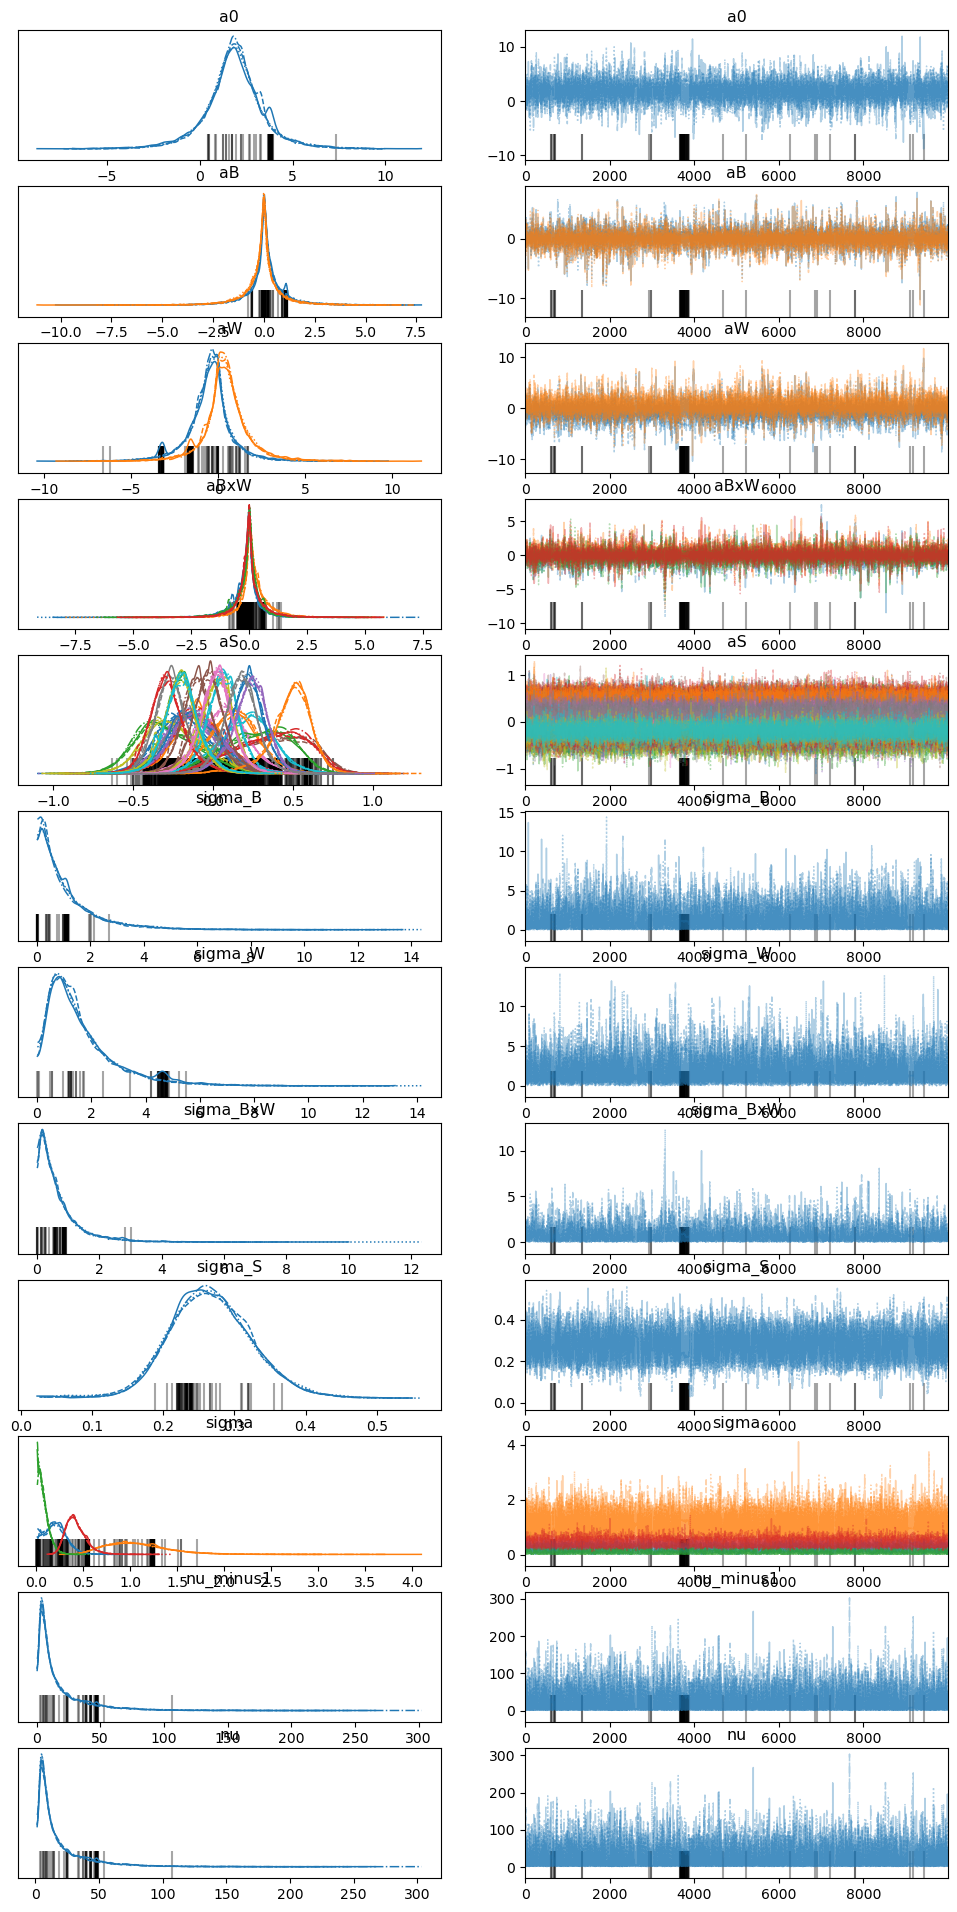

In [ ]:
az.plot_trace(idata_exp_e1);

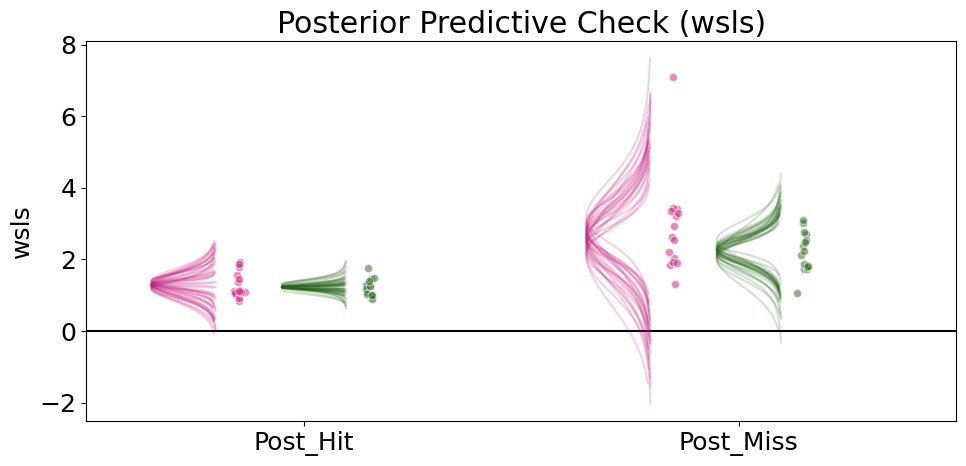

In [ ]:
# Convert coefficients to sum-to-zero deflections
post_exp_e1 = bst.convert_to_sum_to_zero(idata_exp_e1, 
                                         df1_var.group, 
                                         df1_var.exp_time, 
                                         df1_var.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df1_var.group, 
                                       within_subj=df1_var.exp_time, 
                                       y=df1_var.wsls, 
                                       post=post_exp_e1, 
                                       n_mustaches=25)

Interactions:
Posterior for RPE Post_Hit = 1.289 [1.145 1.426]
Posterior for TE Post_Hit = 1.226 [1.165 1.288]
RPE vs TE @ Post_Hit = 0.063 [-0.085  0.214]
 
Posterior for RPE Post_Miss = 2.616 [2.083 3.205]
Posterior for TE Post_Miss = 2.245 [2.009 2.477]
RPE vs TE @ Post_Miss = 0.371 [-0.171  1.013]
 


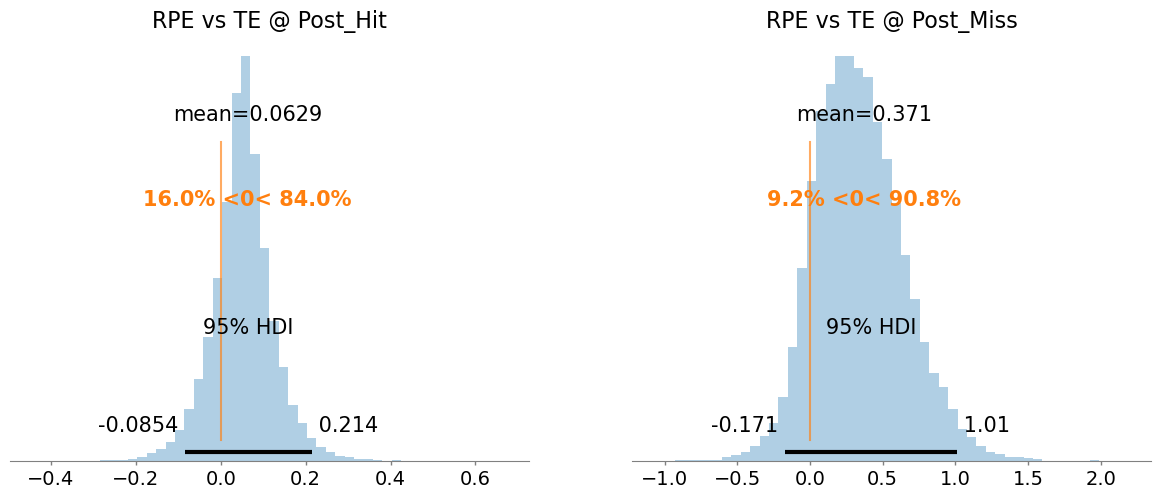

In [ ]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_exp_e1, 
                       between_subj=df1_var.group, 
                       within_subj=df1_var.exp_time, 
                       round_to=3)

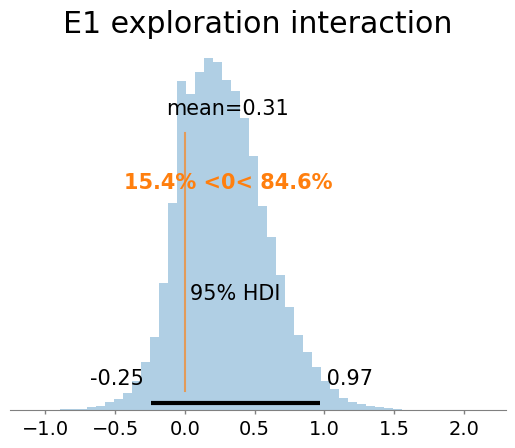

In [35]:
#Interaction effect

#Index posteriors
post_rpe_hit = post_exp_e1.b0 + post_exp_e1.bB.sel(between_subj='RPE') + post_exp_e1.bW.sel(within_subj='Post_Hit') + post_exp_e1.bBxW.sel(between_subj='RPE',within_subj='Post_Hit')
post_te_hit = post_exp_e1.b0 + post_exp_e1.bB.sel(between_subj='TE') + post_exp_e1.bW.sel(within_subj='Post_Hit') + post_exp_e1.bBxW.sel(between_subj='TE',within_subj='Post_Hit')

post_rpe_miss = post_exp_e1.b0 + post_exp_e1.bB.sel(between_subj='RPE') + post_exp_e1.bW.sel(within_subj='Post_Miss') + post_exp_e1.bBxW.sel(between_subj='RPE',within_subj='Post_Miss')
post_te_miss = post_exp_e1.b0 + post_exp_e1.bB.sel(between_subj='TE') + post_exp_e1.bW.sel(within_subj='Post_Miss') + post_exp_e1.bBxW.sel(between_subj='TE',within_subj='Post_Miss')

#Differences
diff_rpe = post_rpe_miss - post_rpe_hit
diff_te = post_te_miss - post_te_hit
e1exp_interaction = diff_rpe - diff_te

#Plot
az.plot_posterior(e1exp_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('E1 exploration interaction')
plt.show()

## Washout

### Implicit aftereffect

In [ ]:
#Run the model
model_washout_e1, idata_washout_e1 = robust_bayesian_mixed_model_anova(between_subj_var=df1.group, 
                                                                       within_subj_var=df1.time, 
                                                                       subj_id=df1.subj_id, 
                                                                       y=df1.washout, 
                                                                       n_draws=n_samples, 
                                                                       rnd_seed=seed_num)

In [ ]:
az.plot_trace(idata_washout_e1);

In [ ]:
# Convert coefficients to sum-to-zero deflections
post_washout_e1 = bst.convert_to_sum_to_zero(idata_washout_e1, 
                                             df1.group, 
                                             df1.time, 
                                             df1.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df1.group, 
                                       within_subj=df1.time, 
                                       y=df1.washout, 
                                       post=post_washout_e1, 
                                       n_mustaches=25)

In [ ]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_washout_e1, 
                       between_subj=df1.group, 
                       within_subj=df1.time, 
                       round_to=3)

In [ ]:
#Interaction effect

#Index posteriors
post_rpe_early_wsh = post_washout_e1.b0 + post_washout_e1.bB.sel(between_subj='RPE') + post_washout_e1.bW.sel(within_subj='Early') + post_washout_e1.bBxW.sel(between_subj='RPE',within_subj='Early')
post_te_early_wsh = post_washout_e1.b0 + post_washout_e1.bB.sel(between_subj='TE') + post_washout_e1.bW.sel(within_subj='Early') + post_washout_e1.bBxW.sel(between_subj='TE',within_subj='Early')

post_rpe_late_wsh = post_washout_e1.b0 + post_washout_e1.bB.sel(between_subj='RPE') + post_washout_e1.bW.sel(within_subj='Late') + post_washout_e1.bBxW.sel(between_subj='RPE',within_subj='Late')
post_te_late_wsh = post_washout_e1.b0 + post_washout_e1.bB.sel(between_subj='TE') + post_washout_e1.bW.sel(within_subj='Late') + post_washout_e1.bBxW.sel(between_subj='TE',within_subj='Late')

#Differences
time_diff_rpe_wsh = post_rpe_early - post_rpe_late
time_diff_te_wsh = post_te_early - post_te_late
washout_interaction = time_diff_rpe - time_diff_te

#Plot
az.plot_posterior(washout_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('Washout interaction')
plt.show()

# Experiment 2

## Learning

### Late learning

In [ ]:
#Run the model
model_lrn_e2, idata_lrn_e2 = BEST(y=df2.late_lrn[df2.time=="Early"], 
                                  group=df2.group[df2.time=="Early"],
                                  n_draws=n_samples, rnd_seed=seed_num)

In [ ]:
az.plot_trace(idata_lrn_e2);

In [ ]:
#Extract posterior
post_lrn_e2 = az.extract(idata_lrn_e2)

#Plot posterior predictive
plot_post_predictive_ttest(df2.late_lrn[df2.time=="Early"], 
                           df2.group[df2.time=="Early"], 
                           post_lrn_e2, 
                           n_samps=20)

In [ ]:
plot_post_simple_comparison(idata_lrn_e2, grp_names, round_to=2)

### Error

In [ ]:
#Run the model
model_error_e2, idata_error_e2 = robust_bayesian_mixed_model_anova(between_subj_var=df2.group, 
                                                                   within_subj_var=df2.time, 
                                                                   subj_id=df2.subj_id, 
                                                                   y=df2.error, 
                                                                   n_draws=n_samples, 
                                                                   rnd_seed=seed_num)

In [ ]:
az.plot_trace(idata_error_e2);

In [ ]:
# Convert coefficients to sum-to-zero deflections
post_error_e2 = bst.convert_to_sum_to_zero(idata_error_e2, 
                                           df2.group, 
                                           df2.time, 
                                           df2.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df2.group, 
                                       within_subj=df2.time, 
                                       y=df2.error, 
                                       post=post_error_e2, 
                                       n_mustaches=25)

In [ ]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_error_e2, 
                       between_subj=df2.group, 
                       within_subj=df2.time, 
                       round_to=3)

In [ ]:
#Interaction effect

#Index posteriors
post_rpe_early = post_error_e2.b0 + post_error_e2.bB.sel(between_subj='RPE') + post_error_e2.bW.sel(within_subj='Early') + post_error_e2.bBxW.sel(between_subj='RPE',within_subj='Early')
post_te_early = post_error_e2.b0 + post_error_e2.bB.sel(between_subj='TE') + post_error_e2.bW.sel(within_subj='Early') + post_error_e2.bBxW.sel(between_subj='TE',within_subj='Early')

post_rpe_late = post_error_e2.b0 + post_error_e2.bB.sel(between_subj='RPE') + post_error_e2.bW.sel(within_subj='Late') + post_error_e2.bBxW.sel(between_subj='RPE',within_subj='Late')
post_te_late = post_error_e2.b0 + post_error_e2.bB.sel(between_subj='TE') + post_error_e2.bW.sel(within_subj='Late') + post_error_e2.bBxW.sel(between_subj='TE',within_subj='Late')

#Differences
time_diff_rpe = post_rpe_early - post_rpe_late
time_diff_te = post_te_early - post_te_late
error_interaction = time_diff_rpe - time_diff_te

#Plot
az.plot_posterior(error_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('Error interaction')
plt.show()

### Percent success

In [ ]:
#Run the model
model_success_e2, idata_success_e2 = robust_bayesian_mixed_model_anova(between_subj_var=df2.group, 
                                                                       within_subj_var=df2.time, 
                                                                       subj_id=df2.subj_id, 
                                                                       y=df2.success, 
                                                                       n_draws=n_samples, 
                                                                       rnd_seed=seed_num)

In [ ]:
az.plot_trace(idata_success_e2);

In [ ]:
# Convert coefficients to sum-to-zero deflections
post_success_e2 = bst.convert_to_sum_to_zero(idata_success_e2, 
                                                 df2.group, 
                                                 df2.time, 
                                                 df2.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df2.group, 
                                       within_subj=df2.time, 
                                       y=df2.success, 
                                       post=post_success_e2, 
                                       n_mustaches=25)

In [ ]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_success_e2, 
                       between_subj=df2.group, 
                       within_subj=df2.time, 
                       round_to=3)

In [ ]:
#Interaction effect

#Index posteriors
post_rpe_early = post_success_e2.b0 + post_success_e2.bB.sel(between_subj='RPE') + post_success_e2.bW.sel(within_subj='Early') + post_success_e2.bBxW.sel(between_subj='RPE',within_subj='Early')
post_te_early = post_success_e2.b0 + post_success_e2.bB.sel(between_subj='TE') + post_success_e2.bW.sel(within_subj='Early') + post_success_e2.bBxW.sel(between_subj='TE',within_subj='Early')

post_rpe_late = post_success_e2.b0 + post_success_e2.bB.sel(between_subj='RPE') + post_success_e2.bW.sel(within_subj='Late') + post_success_e2.bBxW.sel(between_subj='RPE',within_subj='Late')
post_te_late = post_success_e2.b0 + post_success_e2.bB.sel(between_subj='TE') + post_success_e2.bW.sel(within_subj='Late') + post_success_e2.bBxW.sel(between_subj='TE',within_subj='Late')

#Differences
time_diff_rpe = post_rpe_early - post_rpe_late
time_diff_te = post_te_early - post_te_late
success_interaction = time_diff_rpe - time_diff_te

#Plot
az.plot_posterior(success_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('Success interaction')
plt.show()

## Exploration

### Motor Variability

In [ ]:
model_var_e2, idata_var_e2 = robust_bayesian_mixed_model_anova(between_subj_var=df2_var.group, 
                                                               within_subj_var=df2_var.time, 
                                                               subj_id=df2_var.subj_id, 
                                                               y=df2_var.variability, 
                                                               n_draws=n_samples,
                                                               rnd_seed=seed_num)

In [ ]:
az.plot_trace(idata_var_e2);

In [ ]:
# Convert coefficients to sum-to-zero deflections
post_var_e2 = bst.convert_to_sum_to_zero(idata_var_e2, 
                                         df2_var.group, 
                                         df2_var.time, 
                                         df2_var.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df2_var.group, 
                                       within_subj=df2_var.time, 
                                       y=df2_var.variability, 
                                       post=post_var_e2, 
                                       n_mustaches=25)

In [ ]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_var_e2, 
                       between_subj=df2_var.group, 
                       within_subj=df2_var.time, 
                       round_to=3)

In [ ]:
#Interaction effect

#Index posteriors
post_rpe_early = post_var_e2.b0 + post_var_e2.bB.sel(between_subj='RPE') + post_var_e2.bW.sel(within_subj='Early') + post_var_e2.bBxW.sel(between_subj='RPE',within_subj='Early')
post_te_early = post_var_e2.b0 + post_var_e2.bB.sel(between_subj='TE') + post_var_e2.bW.sel(within_subj='Early') + post_var_e2.bBxW.sel(between_subj='TE',within_subj='Early')

post_rpe_late = post_var_e2.b0 + post_var_e2.bB.sel(between_subj='RPE') + post_var_e2.bW.sel(within_subj='Late') + post_var_e2.bBxW.sel(between_subj='RPE',within_subj='Late')
post_te_late = post_var_e2.b0 + post_var_e2.bB.sel(between_subj='TE') + post_var_e2.bW.sel(within_subj='Late') + post_var_e2.bBxW.sel(between_subj='TE',within_subj='Late')

#Differences
time_diff_rpe = post_rpe_early - post_rpe_late
time_diff_te = post_te_early - post_te_late
e2var_interaction = time_diff_rpe - time_diff_te

#Plot
az.plot_posterior(e2var_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('E2 variability interaction')
plt.show()

### Win stay lose shift

In [ ]:
model_exp_e2, idata_exp_e2 = robust_bayesian_mixed_model_anova(between_subj_var=df2_var.group, 
                                                               within_subj_var=df2_var.exp_time, 
                                                               subj_id=df2_var.subj_id, 
                                                               y=df2_var.wsls, 
                                                               n_draws=n_samples,
                                                               rnd_seed=seed_num)

In [ ]:
az.plot_trace(idata_exp_e2);

In [ ]:
# Convert coefficients to sum-to-zero deflections
post_exp_e2 = bst.convert_to_sum_to_zero(idata_exp_e2, 
                                               df2_var.group, 
                                               df2_var.exp_time, 
                                               df2_var.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df2_var.group, 
                                       within_subj=df2_var.exp_time, 
                                       y=df2_var.wsls, 
                                       post=post_exp_e2, 
                                       n_mustaches=25)

In [ ]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_exp_e2, 
                       between_subj=df2_var.group, 
                       within_subj=df2_var.exp_time, 
                       round_to=3)

In [ ]:
#Interaction effect

#Index posteriors
post_rpe_hit = post_exp_e2.b0 + post_exp_e2.bB.sel(between_subj='RPE') + post_exp_e2.bW.sel(within_subj='Post_Hit') + post_exp_e2.bBxW.sel(between_subj='RPE',within_subj='Post_Hit')
post_te_hit = post_exp_e2.b0 + post_exp_e2.bB.sel(between_subj='TE') + post_exp_e2.bW.sel(within_subj='Post_Hit') + post_exp_e2.bBxW.sel(between_subj='TE',within_subj='Post_Hit')

post_rpe_miss = post_exp_e2.b0 + post_exp_e2.bB.sel(between_subj='RPE') + post_exp_e2.bW.sel(within_subj='Post_Miss') + post_exp_e2.bBxW.sel(between_subj='RPE',within_subj='Post_Miss')
post_te_miss = post_exp_e2.b0 + post_exp_e2.bB.sel(between_subj='TE') + post_exp_e2.bW.sel(within_subj='Post_Miss') + post_exp_e2.bBxW.sel(between_subj='TE',within_subj='Post_Miss')

#Differences
diff_rpe = post_rpe_miss - post_rpe_hit
diff_te = post_te_miss - post_te_hit
e2exp_interaction = diff_rpe - diff_te

#Plot
az.plot_posterior(e2exp_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('E2 exploration interaction')
plt.show()

## Retention

### Retention percent

In [ ]:
#Run the model
model_retprct_e2, idata_retprct_e2 = robust_bayesian_mixed_model_anova(between_subj_var=df2.group, 
                                                                       within_subj_var=df2.time_ret, 
                                                                       subj_id=df2.subj_id, 
                                                                       y=df2.ret_prct, 
                                                                       n_draws=n_samples, 
                                                                       rnd_seed=seed_num)

In [ ]:
az.plot_trace(idata_retprct_e2);

In [ ]:
# Convert coefficients to sum-to-zero deflections
post_retprct_e2 = bst.convert_to_sum_to_zero(idata_retprct_e2, 
                                                 df2.group, 
                                                 df2.time_ret, 
                                                 df2.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df2.group, 
                                       within_subj=df2.time_ret, 
                                       y=df2.ret_prct, 
                                       post=post_retprct_e2, 
                                       n_mustaches=25)

In [ ]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_retprct_e2, 
                       between_subj=df2.group, 
                       within_subj=df2.time_ret, 
                       round_to=3)

In [ ]:
#Interaction effect

#Index posteriors
post_rpe_immediate = post_retprct_e2.b0 + post_retprct_e2.bB.sel(between_subj='RPE') + post_retprct_e2.bW.sel(within_subj='Immediate') + post_retprct_e2.bBxW.sel(between_subj='RPE',within_subj='Immediate')
post_te_immediate = post_retprct_e2.b0 + post_retprct_e2.bB.sel(between_subj='TE') + post_retprct_e2.bW.sel(within_subj='Immediate') + post_retprct_e2.bBxW.sel(between_subj='TE',within_subj='Immediate')

post_rpe_24hr = post_retprct_e2.b0 + post_retprct_e2.bB.sel(between_subj='RPE') + post_retprct_e2.bW.sel(within_subj='24hr') + post_retprct_e2.bBxW.sel(between_subj='RPE',within_subj='24hr')
post_te_24hr = post_retprct_e2.b0 + post_retprct_e2.bB.sel(between_subj='TE') + post_retprct_e2.bW.sel(within_subj='24hr') + post_retprct_e2.bBxW.sel(between_subj='TE',within_subj='24hr')

#Differences
diff_rpe = post_rpe_immediate - post_rpe_24hr
diff_te = post_te_immediate - post_te_24hr
retprct_interaction = diff_rpe - diff_te

#Plot
az.plot_posterior(retprct_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('Retention percent interaction')
plt.show()

### Retention accuracy

In [ ]:
#Run the model
model_reterr_e2, idata_reterr_e2 = robust_bayesian_mixed_model_anova(between_subj_var=df2.group, 
                                                                     within_subj_var=df2.time_ret, 
                                                                     subj_id=df2.subj_id, 
                                                                     y=df2.ret_error, 
                                                                     n_draws=n_samples, 
                                                                     rnd_seed=seed_num)

In [ ]:
az.plot_trace(idata_reterr_e2);

In [ ]:
# Convert coefficients to sum-to-zero deflections
post_reterr_e2 = bst.convert_to_sum_to_zero(idata_reterr_e2, 
                                            df2.group, 
                                            df2.time_ret, 
                                            df2.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova_robust(between_subj=df2.group, 
                                       within_subj=df2.time_ret, 
                                       y=df2.ret_error, 
                                       post=post_reterr_e2, 
                                       n_mustaches=25)

In [ ]:
#Between subject contrasts at both timepoints
plot_between_contrasts(post_reterr_e2, 
                       between_subj=df2.group, 
                       within_subj=df2.time_ret, 
                       round_to=3)

In [ ]:
#Interaction effect

#Index posteriors
post_rpe_immediate = post_reterr_e2.b0 + post_reterr_e2.bB.sel(between_subj='RPE') + post_reterr_e2.bW.sel(within_subj='Immediate') + post_reterr_e2.bBxW.sel(between_subj='RPE',within_subj='Immediate')
post_te_immediate = post_reterr_e2.b0 + post_reterr_e2.bB.sel(between_subj='TE') + post_reterr_e2.bW.sel(within_subj='Immediate') + post_reterr_e2.bBxW.sel(between_subj='TE',within_subj='Immediate')

post_rpe_24hr = post_reterr_e2.b0 + post_reterr_e2.bB.sel(between_subj='RPE') + post_reterr_e2.bW.sel(within_subj='24hr') + post_reterr_e2.bBxW.sel(between_subj='RPE',within_subj='24hr')
post_te_24hr = post_reterr_e2.b0 + post_reterr_e2.bB.sel(between_subj='TE') + post_reterr_e2.bW.sel(within_subj='24hr') + post_reterr_e2.bBxW.sel(between_subj='TE',within_subj='24hr')

#Differences
diff_rpe = post_rpe_immediate - post_rpe_24hr
diff_te = post_te_immediate - post_te_24hr
reterr_interaction = diff_rpe - diff_te

#Plot
az.plot_posterior(reterr_interaction, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=2,
                  hdi_prob=0.95);
plt.title('Retention error interaction')
plt.show()

### Post hoc analysis

#### Load data

In [ ]:
#Organize the data
dfp = pd.read_csv('E2_sub_regress.txt', dtype={'LSLperception':'category','group':'category'})
dfp_imm = dfp[dfp.time=='Immediate']
dfp_24 = dfp[dfp.time=='24hr']

ordered_y = np.zeros(len(dfp_imm), dtype=int)
ordered_y[dfp_imm.LSLperception=='slightly longer'] = int(1)
ordered_y[dfp_imm.LSLperception=='longer'] = int(2)

x_grp, x_levels_grp, n_levels_grp = bst.parse_categorical(dfp_imm.group)

#### Difference in perception

In [ ]:
with pm.Model() as model:
    c = pm.Normal("c", 
                  mu=[-1,1], 
                  sigma=20,
                  transform=pm.distributions.transforms.ordered)
    mu = pm.Normal("mu", mu=0, sigma=4, shape=2)
    
    y = pm.OrderedProbit("y", cutpoints=c, eta=mu[x_grp], observed=ordered_y)
    tr = pm.sample(1000)

In [ ]:
az.plot_trace(tr);

In [ ]:
az.plot_posterior(tr,
                  combine_dims={"sample"},
                  var_names=["mu"],
                  kind="hist",
                  bins=50,
                  hdi_prob=0.95,
                  point_estimate="mean",
                  ref_val=0,
                  round_to=3);

In [ ]:
# Group difference
post_percept = az.extract(tr.posterior)
group_diff = post_percept.mu.values[0] - post_percept.mu.values[1]

az.plot_posterior(group_diff,
                  combine_dims={"sample"},
                  kind="hist",
                  bins=50,
                  hdi_prob=0.95,
                  point_estimate="mean",
                  ref_val=0,
                  round_to=3);
plt.title('Group effect (rpe - te)')
plt.show()

#### Immediate retention regression

In [ ]:
perception_cat5 = pd.Categorical(dfp_imm.LSLperception.values, categories=["not longer", "slightly longer", "longer"], ordered=True)

idata_percept5, posterior_percept5 = perception_regression(x_percept=perception_cat5.codes, 
                                                           y=dfp_imm.ret_prct, 
                                                           group=dfp_imm.group)

In [ ]:
az.plot_posterior(posterior_percept5,
                  combine_dims={"sample"},
                  var_names=["alpha_group", "beta_percept", "delta"],
                  kind="hist",
                  bins=50,
                  hdi_prob=0.95,
                  point_estimate="mean",
                  ref_val=0,
                  round_to=3);

In [ ]:
group_diff = posterior_percept5.alpha_group.sel(group='te') - posterior_percept5.alpha_group.sel(group='rpe')
az.plot_posterior(group_diff,
                  combine_dims={"sample"},
                  kind="hist",
                  bins=50,
                  hdi_prob=0.95,
                  point_estimate="mean",
                  ref_val=0,
                  round_to=3);
plt.title('group difference')
plt.show()

In [ ]:
posterior_predictive_regression(posterior_percept5, perception_cat5, dfp_imm)

#### 24-hour

In [ ]:
perception_cat24 = pd.Categorical(dfp_24.LSLperception.values, categories=["not longer", "slightly longer", "longer"], ordered=True)

idata_percept24, posterior_percept24 = perception_regression(x_percept=perception_cat24.codes, 
                                                             y=dfp_24.ret_prct, 
                                                             group=dfp_24.group)

In [ ]:
az.plot_posterior(posterior_percept24,
                  combine_dims={"sample"},
                  var_names=["alpha_group", "beta_percept", "delta"],
                  kind="hist",
                  bins=50,
                  hdi_prob=0.95,
                  point_estimate="mean",
                  ref_val=0,
                  round_to=3);

In [ ]:
group_diff = posterior_percept24.alpha_group.sel(group='te') - posterior_percept24.alpha_group.sel(group='rpe')
az.plot_posterior(group_diff,
                  combine_dims={"sample"},
                  kind="hist",
                  bins=50,
                  hdi_prob=0.95,
                  point_estimate="mean",
                  ref_val=0,
                  round_to=3);
plt.title('group difference')
plt.show()

In [ ]:
posterior_predictive_regression(posterior_percept24, perception_cat24, dfp_24)

#### Combined groups

In [ ]:
def perception_regression_comb(x_percept, y):
    
    
    with pm.Model() as model:
        # Define priors
        alpha_group = pm.Normal("alpha_group", mu=100, sigma=100)
        beta_percept = pm.Normal("beta_percept", mu=0, sigma=100)

        delta = pm.Dirichlet("delta", np.repeat(2.0,2), shape=2)
        delta_j = at.concatenate([at.zeros(1), delta])
        delta_j_cumulative = at.cumsum(delta_j)

        mu = alpha_group + beta_percept*delta_j_cumulative[x_percept]
        sigma = pm.Uniform("sigma", 10**-10, 1000)

        nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29)
        nu = pm.Exponential("nu", nu_minus_one + 1)
        nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))

        # Define likelihood
        likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, lam=1 / sigma**2, observed=y)

        # Sample the posterior
        idata = pm.sample(draws=n_samples, tune=2000, target_accept=0.95, random_seed=seed_num, chains=4, cores=8, init='auto')
        
    az.plot_trace(idata);

    posterior = az.extract(idata.posterior)

    return idata, posterior

In [ ]:
perception_cat5 = pd.Categorical(dfp_imm.LSLperception.values, categories=["not longer", "slightly longer", "longer"], ordered=True)

idata_percept5_comb, posterior_percept5_comb = perception_regression_comb(x_percept=perception_cat5.codes, 
                                                                          y=dfp_imm.ret_prct)

In [ ]:
az.plot_posterior(idata_percept5_comb,
                  combine_dims={"sample"},
                  var_names=["alpha_group", "beta_percept", "delta"],
                  kind="hist",
                  bins=50,
                  hdi_prob=0.95,
                  point_estimate="mean",
                  ref_val=0,
                  round_to=3);

In [ ]:
perception_cat24 = pd.Categorical(dfp_24.LSLperception.values, categories=["not longer", "slightly longer", "longer"], ordered=True)

idata_percept24_comb, posterior_percept24_comb = perception_regression_comb(x_percept=perception_cat24.codes, 
                                                                            y=dfp_24.ret_prct)

In [ ]:
az.plot_posterior(idata_percept24_comb,
                  combine_dims={"sample"},
                  var_names=["alpha_group", "beta_percept", "delta"],
                  kind="hist",
                  bins=50,
                  hdi_prob=0.95,
                  point_estimate="mean",
                  ref_val=0,
                  round_to=3);

In [ ]:
compare_dict = {"Combined": idata_percept24_comb,
                "Individual": idata_percept24}
comp_results = az.compare(compare_dict, ic="waic")
comp_results

In [ ]:
compare_dict = {"Combined": idata_percept5_comb,
                "Individual": idata_percept5}
comp_results = az.compare(compare_dict, ic="waic")
comp_results

# Save HDIs for plotting

In [ ]:
az.hdi(post_rpe_early.values, hdi_prob=0.95)


In [ ]:
constrast_hdi_dict = {"lrn_e1_rpe": az.hdi(post.group_mean.values[0], hdi_prob=0.95),
                      "lrn_e1_te": az.hdi(post.group_mean.values[1], hdi_prob=0.95),
                      "wsh_e1_rpe": az.hdi(post_rpe_early_wsh.values, hdi_prob=0.95),
                      "wsh_e1_te": az.hdi(post_te_early_wsh.values, hdi_prob=0.95),

                     }
                        


In [ ]:
constrast_hdi_dict = {"fb_interactions": az.hdi(interaction_contrast_fb.values, hdi_prob=0.95),
                      "aftereffect_diff": az.hdi(wsh_diff.values, hdi_prob=0.95), 
                      "afast_diff": az.hdi(post_Afast["difference of means"].values, hdi_prob=0.95),
                      "aslow_diff": az.hdi(post_Aslow["difference of means"].values, hdi_prob=0.95),
                      "bfast_diff": az.hdi(post_Bfast["difference of means"].values, hdi_prob=0.95),
                      "bslow_diff": az.hdi(post_Bslow["difference of means"].values, hdi_prob=0.95),
                      "vc_diff": az.hdi(post_vc["difference of means"].values, hdi_prob=0.95)}
post_hdi_df = pd.DataFrame(constrast_hdi_dict, index=['2.5%', '97.5%'])
post_hdi_df.to_csv(data_dir + '/posterior_hdi_table.csv')